Write a program that predicts the price of gold using the ARIMA time series in Python. The code could be provided either as `py` or `ipynb` file.
Send the output graphs along with the code. Provide a short description of how to implement and calculate. You can use any of the packages or the libraries.

Pedram Asshabi
+98 933 666 88 78

# ARIMA Models

_ARIMA stands for Autoregressive Integrated Moving Average_

    A couple of notes here:
    - Finance data such as stock prices or gold data in this case is not a time series data that is directly a function of time.
    - So ARIMA is not capable of prefectly predicting any time series data like that.
    - And I am totaly new in time series..

**Contents:**

* STEP 1: TIME SERIES DECOMPOSITION PLOT

* STEP 2: DETERMINE THE ARIMA TERMS

* STEP 3: BUILD AND VALIDATE THE ARIMA MODEL

* STEP 4: FORECAST!

## Import the modules:

In [261]:
import matplotlib.pyplot as plt
from pylab import rcParams

import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from pmdarima import auto_arima

import itertools

from sklearn.metrics import mean_absolute_error, mean_squared_error


## Import the Dataset:

In [272]:
# df = pd.read_csv("XAUUSD.csv", index_col="Date", parse_dates=True)
raw_df = pd.read_csv("XAUUSD.csv")

raw_df.Date = pd.to_datetime(raw_df['Date'])
raw_df = raw_df.set_index('Date').asfreq('B')  # Take workdays as frequency.

# todo: try to predict with resampleing montly:
# df.resample('M').mean()

# df.dropna(inplace=True)
# df = df.fillna(method='ffill')
raw_df

,Open,High,Low,Close,Change(Pips),Change(%)
Date,,,,,,
2021-07-05,1786.68,1794.00,1783.80,1791.15,447,0.25
2021-07-06,1790.85,1814.89,1789.89,1795.68,483,0.27
2021-07-07,1795.28,1809.50,1793.41,1803.22,794,0.44
2021-07-08,1803.29,1818.00,1793.90,1803.75,46,0.03
2021-07-09,1803.87,1812.38,1796.53,1807.89,402,0.22
...,...,...,...,...,...,...
2023-06-28,1915.26,1916.98,1903.46,1909.58,-568,-0.30
2023-06-29,1909.47,1913.00,1893.16,1908.76,-71,-0.04
2023-06-30,1908.71,1922.61,1900.57,1919.20,1049,0.55


In [256]:
# from sklearn.impute import KNNImputer

# knn_imputer = KNNImputer()

# df.fillna()
# df_imputed = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)
# df_imputed

<AxesSubplot:xlabel='Date', ylabel='price'>

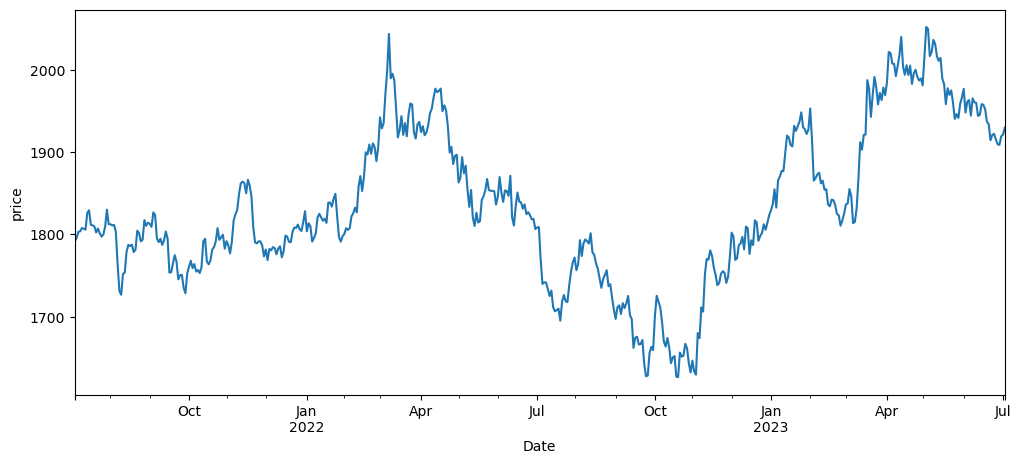

In [265]:
rcParams['figure.figsize'] = 12, 5

raw_df['Close'].plot(ylabel="price")

## Looking at the data:

All features in this data set are highly correlated. As we can see, `Change (%)` and `Change pips` are same values in different scale.

`Open`, `high`, `low`, and `close`, all could be treated as either features or Y label that we're going to predict. 
- Note we can't use column's features for rowth *i* (time *t*) as they are; because we don't have access to these features in the future for prediction. Althogh, if you ask me, they all are contributing to the gold price for the future. So, one way is maybe to combine these columns (e.g. averaging over them) and take that as our Y output, or ...

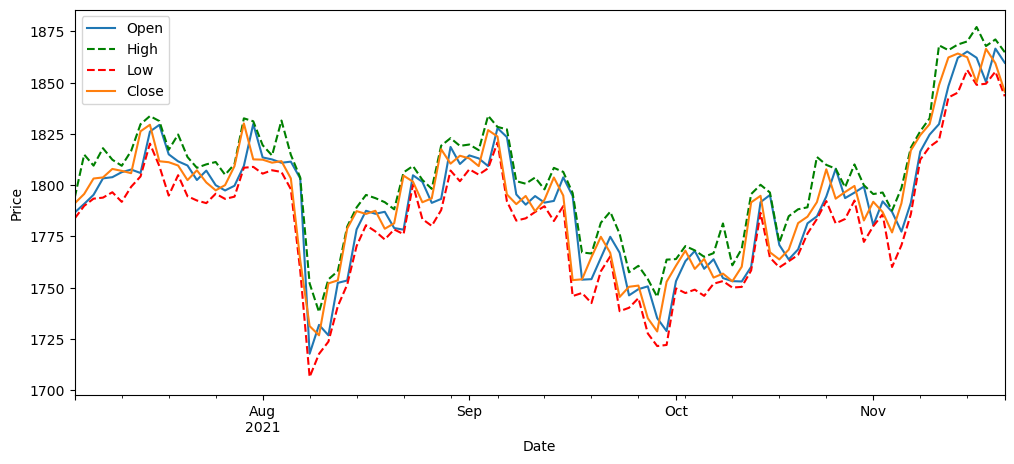

In [347]:
ax = raw_df['Open'].iloc[:100].plot(ylabel='Price')
raw_df['High'].iloc[:100].plot(ls='--', c='g')
raw_df['Low'].iloc[:100].plot(ls='--', c='r')
raw_df['Close'].iloc[:100].plot()

 ax.legend(raw_df.columns[:3].tolist() + ['Close'])

## Towards making the model

My procedure for prediction the gold price is to predict for `Close` column. In other word, `Close` column is our Y label. Since it is the closing value/price for that day.
Our model is going to predict (as I want this and there is no constraint about this) for the next 7 days at most, I'm going to make each Y label dependent to last 7 days, In this way I can benefits from having features along the time series. I set a variabel name `prediction range` or `predict_range` in order to be open for other posibilites.

In [308]:
predict_range = 7 # default value is 7

old_feature_col_name = raw_df.columns.drop('Close')  # take `Close` col as Y label and other colmns as features.

profix = '-' + str(predict_range)
feature_col_name = old_feature_col_name + profix # change features name and add [-predict_range] or -7 to them.

df = raw_df.copy()
df[feature_col_name] = raw_df[old_feature_col_name].shift(predict_range) # each Lable now depends on features columns of the [predic_range] (default 7) days ago.


df = df.drop(old_feature_col_name, axis=1)
df = df[predict_range:]  # trunicate tha NaN's feature rows
print("number of samplpe in original data frame:", raw_df.shape[0])
print("number of samplpe in our dataframe:", df.shape[0])
df

number of samplpe in original data frame: 522
number of samplpe in our dataframe: 515


,Close,Open-7,High-7,Low-7,Change(Pips)-7,Change(%)-7
Date,,,,,,
2021-07-14,1826.23,1786.68,1794.00,1783.80,447.0,0.25
2021-07-15,1829.43,1790.85,1814.89,1789.89,483.0,0.27
2021-07-16,1811.64,1795.28,1809.50,1793.41,794.0,0.44
2021-07-19,1811.17,1803.29,1818.00,1793.90,46.0,0.03
2021-07-20,1809.56,1803.87,1812.38,1796.53,402.0,0.22
...,...,...,...,...,...,...
2023-06-28,1909.58,1957.00,1958.49,1947.80,-481.0,-0.25
2023-06-29,1908.76,1952.39,1956.39,1929.00,-1533.0,-0.79
2023-06-30,1919.20,1935.90,1939.08,1920.19,-199.0,-0.10


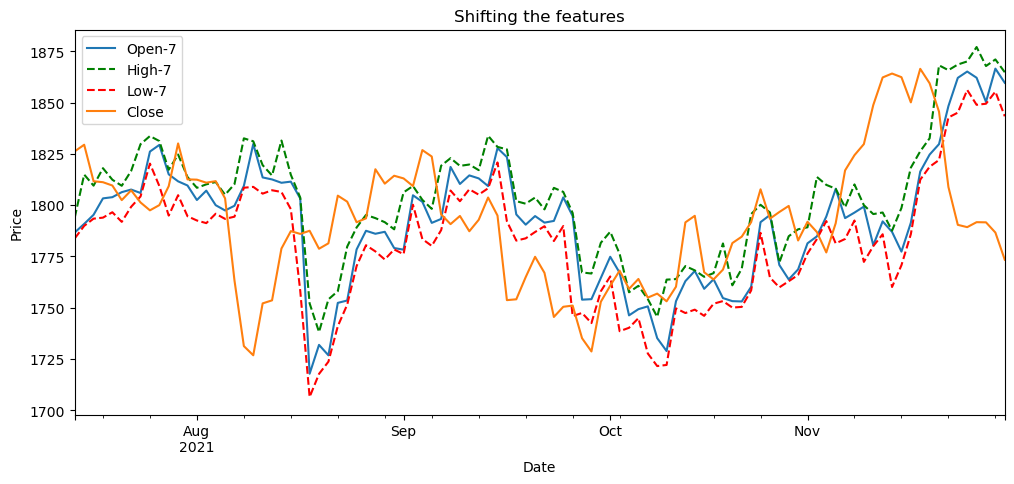

In [345]:
ax = df['Open-7'].iloc[:100].plot(ylabel='Price', title="Shifting the features")
df['High-7'].iloc[:100].plot(ls='--', c='g')
df['Low-7'].iloc[:100].plot(ls='--', c='r')
df['Close'].iloc[:100].plot()
ax.legend(feature_col_name[:3].tolist() + ['Close'])

Let’s see if there is some cross-correlation in our data. As shown in the plots there is certain high correlation between time t and t-1 to t-3 and it gradually decreases for t4 to t-8 and so on..

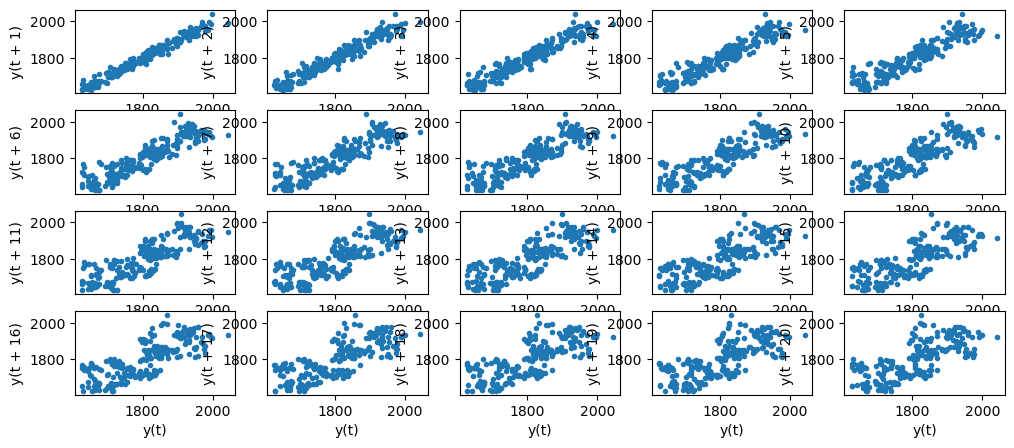

In [293]:
fig, ax = plt.subplots(4, 5)

row = -1
for i in range(20):
    
    col = i%5
    if col%5 == 0:
        row += 1
    
    pd.plotting.lag_plot(df['Close']['01-01-2022':'12-01-2022'], lag=i+1, ax=ax[row, col], marker='.')

## STEP 1: TIME SERIES DECOMPOSITION PLOT

A time series decomposition plot allows us to observe the seasonality, trend, and error/remainder terms of a time series.

#### TIME SERIES DECOMPOSITION PLOT
- Step 1 - Check stationarity: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. Use the TS Plot tool to see if the time series is stationary.
- Step 2 - Difference: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
- Step 3 - Filter out a validation sample: This will be used to validate how accurate our model is. Use the last 6 periods as the validation sample.
- Step 4 - Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.

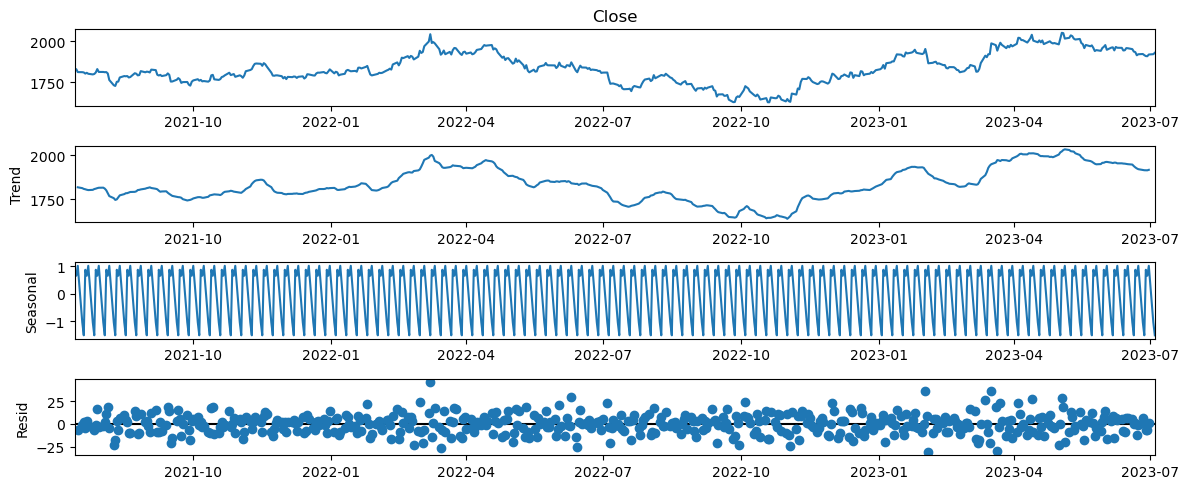

In [294]:
# ETS Decomposition:
decompostion = seasonal_decompose(df['Close'], model='add')
decompostion.plot();

Some Observation: 

    - Data is none stationery.
    - There is no trend
    - There is sesonality about 7 days.
    - A Multiplicative model is not appropriate when we are increasing or decreasing at a linear rate.

<AxesSubplot:xlabel='Date'>

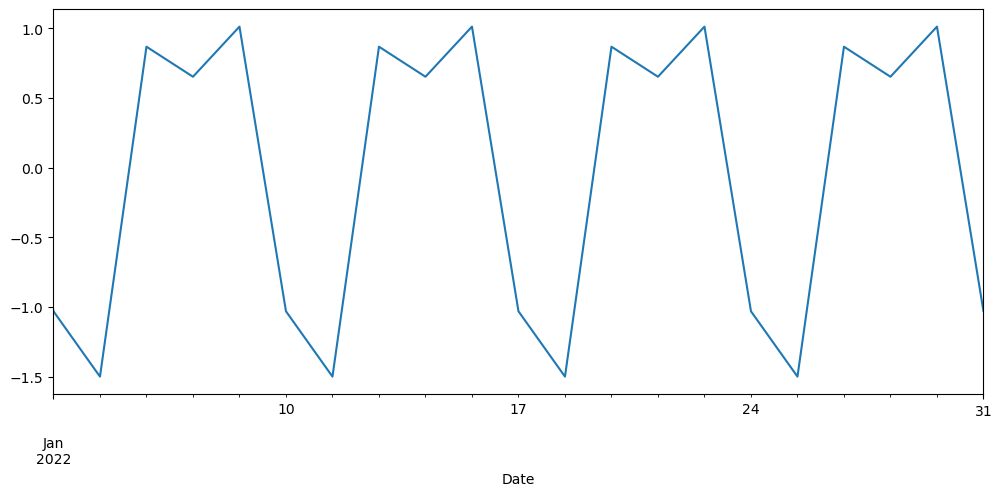

In [295]:
decompostion.seasonal.plot(xlim=['01-01-2022','01-31-2022'])  # plot one month of data sesonality!
# the patterns repates itself weekly!

## STEP 2: DETERMINE THE ARIMA TERMS

Nonseasonal ARIMA models are displayed in the terms (p,d,q) which stand for p - periods to lag for, d - number of transformations used to make the data stationary, q - lags of the error component

- Stationary - mean and variance are constant over time vs Non-Stationary - mean and variance change over time
- Differencing - take the value in the current period and subtract it by the value from the previous period. We might have to do this several times to make the data stationary. This is the Integrated component which is d in the model terms.
- Autocorrelation - How correlated a time series is with its past values, if positive at Lag-1 then AR if negative then MA
- Partial Autocorrelation - The correlation between 2 variables controlling for the values of another set of variables. If the partial autocorrelation drops of quickly then AR terms, if it slowly decays then MA

Seasonal ARIMA models are denoted (p,d,q)(P,D,Q)m

These models may require seasonal differencing in addition to non-seasonal differencing. Seasonal differencing is when we subtract the value from a year previous of the current value.


In [296]:
# Double check stationary/none stationary!!

p_value = adfuller(df['Close'])[1]
if p_value <= 0.05:
    print(f"{p_value:.2f} - ", "Data is Stationary based on adlfuler")
else:
    print(f"{p_value:.2f} -", "Data is non stationary")
    # we know our data is none stationery since we have seasonal pick every week  (7 days) !


0.49 - Data is non stationary


#### Identification of ARIMA model:

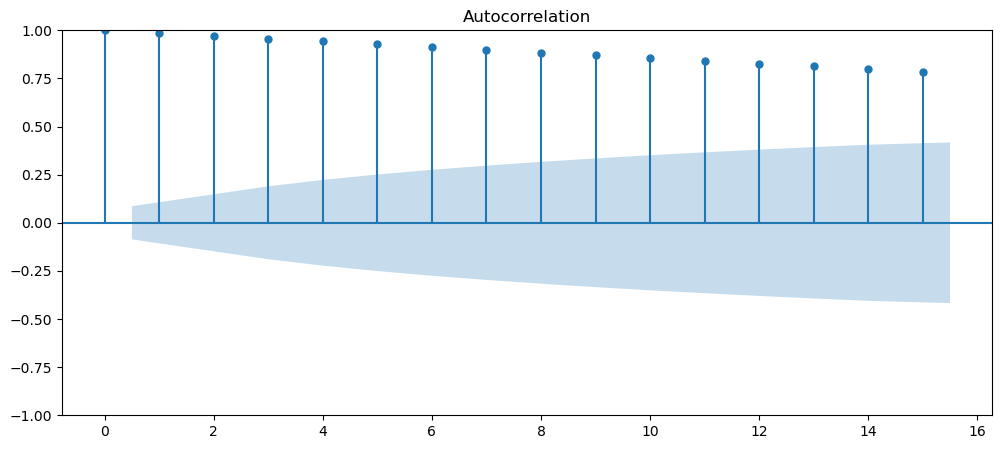

In [297]:
#lags = lag_plot(df['Close'])a
plot_acf(df['Close'], lags=15);

Sharp drop with pacf below suggest us to use AR of the ARIMA model with k = 2.

c:\Users\passh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


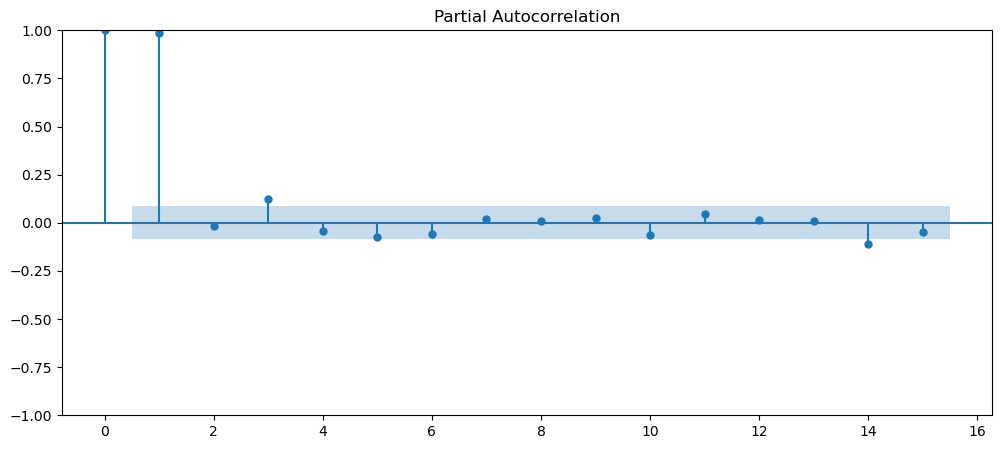

In [298]:
plot_pacf(df['Close'], lags=15);

# STEP 3: BUILD AND VALIDATE THE ARIMA MODEL

Build the ARIMA model using the terms determined in step 2. We can use train and validation/dev_test to validate the quality of the model.

- train: Look at in-sample error measures, particularly RMSE (Root-Mean-Square Error) and MASE (Mean Absolute Scaled Error).
- validation: Determine the accuracy measures by comparing the forecasted values with the holdout sample. This is especially important for comparing ARIMA models to other types of models, such as ETS.

We pick the ARIMA model with lowest AIC value. If the AIC values are comparable, we use calculated errors to pick one that minimizes error the most.

### Train and validation split:
My goal is to predict the price of the gold for the `next 7 days` ahead at maximum. Hence, I split data in that manner. Ideally the test should be at least as large as what we're going to forecast into the future.

In [300]:
val_percent = 0.05  # prcent of data that we take as validation set. 

n_samples, _ = df.shape

val_size = int(n_samples * val_percent)  # take %val_percent of data as validation set.
train_size = n_samples - val_size                           

print("Number of data:", n_samples)
print("Train size:", train_size,)
print("validation size:",  val_size)


train_df = df.iloc[:train_size]
val_df = df.iloc[train_size: n_samples]

Number of data: 515
Train size: 490
validation size: 25


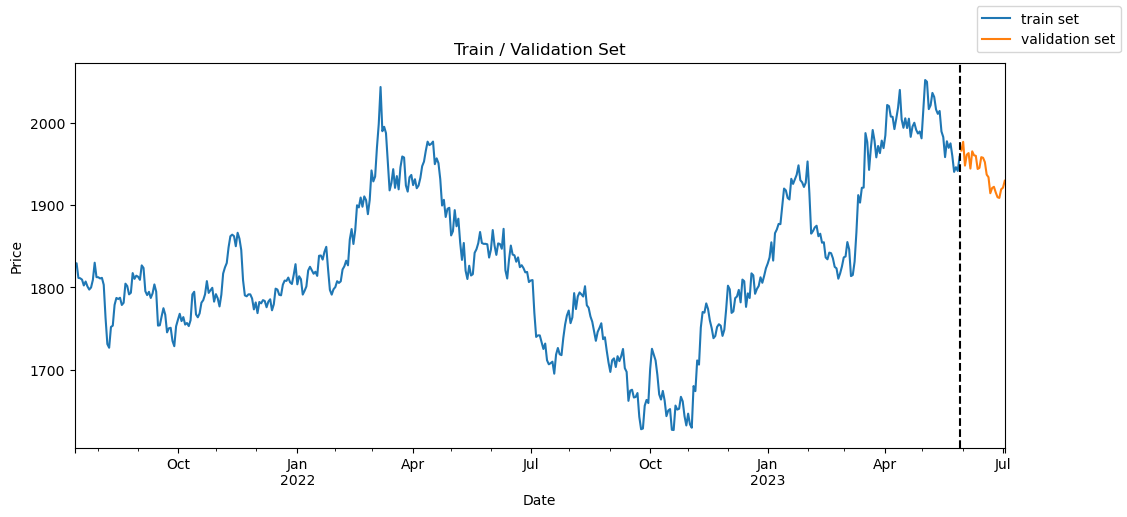

In [301]:
fig, ax = plt.subplots()
train_df['Close'].plot(ylabel="Price", title="Train / Validation Set")
val_df['Close'].plot()

fig.legend(['train set', 'validation set'])
ax.axvline(train_df.index.max(), c='black', ls='--')

In [302]:
# a model as baseline

model = ExponentialSmoothing(train_df['Close'],
                             trend=None,
                             seasonal="add",
                             seasonal_periods=20).fit()

es_predict_val = model.forecast(val_size).rename("Exponential Smoothings")

## ARIMA Model
1. AR           ->   P
2. MA           ->   q
3. Integrated   ->   d

#### Find prameters using auto arima: 

In [304]:
# Find the parameters of ARIMA Model:
auto_arima_param = auto_arima(df['Close'], d=1, D=1, m=15, exog=[feature_col_name])
auto_arima_param

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 15),
      suppress_warnings=True, with_intercept=False)

### TRAIN ARIMA model:

In [310]:

model = SARIMAX(train_df['Close'],
                order = auto_arima_param.order, # parameters based on Auto ARIMA:
                seasonal_order = auto_arima_param.seasonal_order,
                exog=train_df[feature_col_name],
                trend=None).fit(maxiter=1000)

# fitted_model.summary()

arima_predict = model.forecast(val_size, exog=val_df[feature_col_name]).rename('SARIMA model')  # predict as length of the validation set.

## Evaluation the Model:

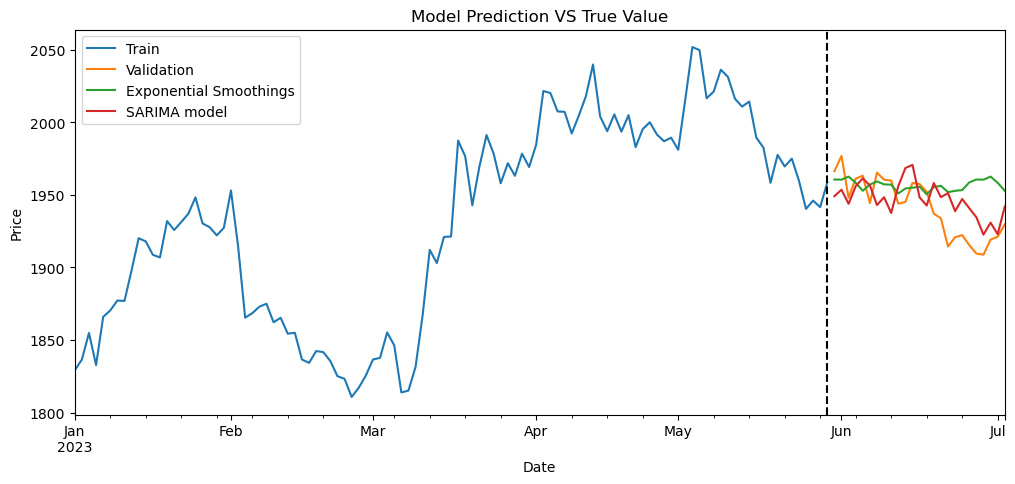

In [311]:
# fig, ax = plt.subplots()
# todo: shows only a last x portion of train data base on split.
ax = train_df['Close']["01-01-2023":].plot(ylabel="Price", title="Model Prediction VS True Value")
val_df['Close'].plot(legend=1).legend(labels=["Train", "Validation"])

es_predict_val.plot(legend=1)
arima_predict.plot(legend=1)

ax.axvline(train_df.index.max(), c='black', ls='--')


### Metrics

In [312]:
# compare prediction on validation set with true value of validation set:
y_val = val_df.Close 
print("mean absolute error:", mean_absolute_error(y_val, arima_predict))
print("mean squared error:", mean_squared_error(y_val, arima_predict))
# val_df.describe()

mean absolute error: 15.701535090818652
mean squared error: 316.39219131031376


## STEP 4: FORECAST!

We use the best ARIMA model to forecast for the desired time period. We make sure to add the holdout sample (validation set) back into the model because they are the most recent data that required for forecasting future. Plot the results along with 80% and 95% confidence intervals.

In [317]:
# parameters based on Auto ARIMA:
model = SARIMAX(df['Close'],
                order = auto_arima_param.order, # parameters based on Auto ARIMA:
                seasonal_order = auto_arima_param.seasonal_order,
                exog=df[feature_col_name],
                trend=None).fit(maxiter=500)

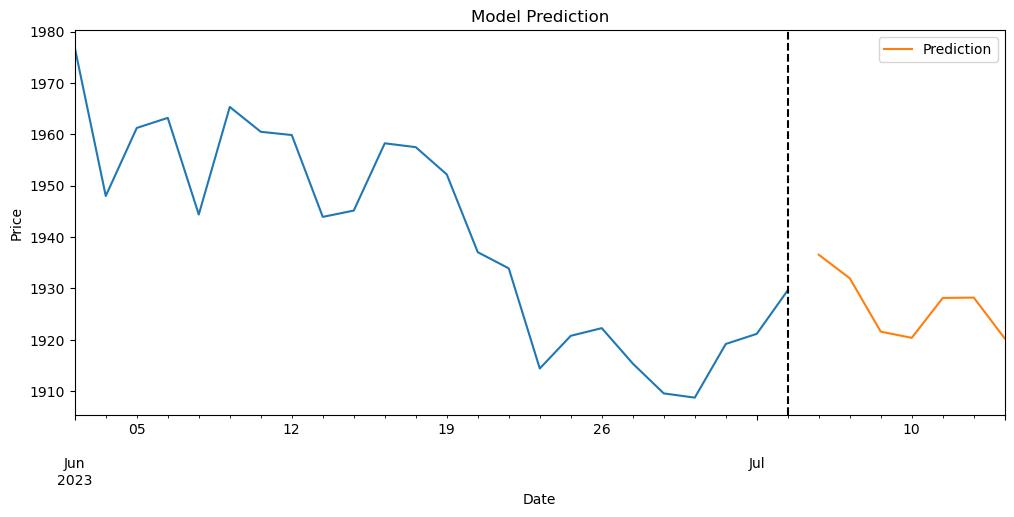

In [328]:
# predict using the model that we created so far

# now predicing on the next [predict_range] days (t+7):
predict = model.forecast(predict_range, exog=df[feature_col_name].iloc[-predict_range:]).rename('Prediction')

ax = df['Close']["06-01-2023":].plot(ylabel="Price", title="Model Prediction")
predict.plot(legend=1)
ax.axvline(df.index.max(), c='black', ls='--')


Here we did prediction for next 7 days. We can change this number. And also We only depend each row to only 7 days ago.
We could do better than that and use all the seven days and not 1 out of 7, one path in this way could also lead to overfitting the model. 
Definitely there is many things to try and improve the model.